In [18]:
'''
TEST SCRIPT

Type: Module testing
Original Script: slampf.py
Class: slampf.py
Methods: ALL
Details: Test slam output for single particle, single control, uniform map 
Outcome: SUCCESSFUL

1. Particle maps aren't updating  - FIXED
2. The guestbook for each particle is updating twice on each real msmt - FIXED
3. Add extended print statements to probe single particle, single control SLAM - DONE

Theory Qns: 
1. Are we doing better than randomly measuring qubits on the grid?
2. Is the likelihood function correct?
3. What is the threshold to stop the algorithm?
4. What happens if we average over the same region again and again? Do we lose info by averaging using the scanner?
5. What if we visit a qubit and it's four neighbours? Does the averaging process give us more or less info? 
6. For (5), is there a combination of physical and quasi msmts that are optimal? 
7. How does increasing the number of particles reduce state variance? Where does it flatline?
8. How do we compare global_bot, particle map and true maps?
'''

import sys, os
import numpy as np
import matplotlib.pyplot as plt 
sys.path.append('../')
from qslam.slampf import ParticleFilter
from qslam.mapping import TrueMap
from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

###############################################################################
# TESTS 
###############################################################################

slamize = ParticleFilter(num_p=1, localgridcoords_=[5,5])
map_ = np.ones((5,5))*np.pi*0.75
dunk = TrueMap(m_vals=map_)
controls = [(2, 2, 10.)]*1# + [(2, 1, 10.)]*1 + [(1, 2, 10.)]*1 + [(2, 3, 10.)]*1 + [(3, 2, 10.)]*1
loopcontrols = controls*5#, (0, 1, 1)]# , (2, 2, 1), (1, 3, 1), (3, 1, 1)]*100

#print loopcontrols

In [19]:
with suppress_stdout():
    slamize.qslam_run(dunk, loopcontrols)

In [20]:
'''From a Single Posterior State Particle'''
print slamize.particles[0].r_questbk

[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.2  0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]]


In [21]:
'''From Global Bot (Scanner)'''
print slamize.global_bot.r_guestbk_counter
print slamize.global_bot.r_questbk

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.2  0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]]


In [22]:
'''Compare True Maps to Maps from Particle (Quasi and Physical Msmts) and Global Bot (Physical)'''
print "True Map"
print map_
print
print "Particle Map"
print slamize.particles[0].m_vals
print 
print "Global Bot Map"
inferred_m_vals = np.asarray([slamize.particles[0].get_phase_method(val) for val in slamize.global_bot.r_questbk.flatten()]).reshape(5,5)
print inferred_m_vals


'''
Notes
1. Where the bot has NOT physically visited (off control path), global_bot.m_vals == pi and partcicles[i].m_vals == 0 are equivalent
2. For zero correlation length in the control path, both maps should be the same
3. For physically measured qubits, both maps should be the same asympotically as long thigns are "continuous"

'''

True Map
[[ 2.35619449  2.35619449  2.35619449  2.35619449  2.35619449]
 [ 2.35619449  2.35619449  2.35619449  2.35619449  2.35619449]
 [ 2.35619449  2.35619449  2.35619449  2.35619449  2.35619449]
 [ 2.35619449  2.35619449  2.35619449  2.35619449  2.35619449]
 [ 2.35619449  2.35619449  2.35619449  2.35619449  2.35619449]]

Particle Map
[[ 3.14159265  3.14159265  3.14159265  3.14159265  3.14159265]
 [ 3.14159265  3.14159265  3.14159265  3.14159265  3.14159265]
 [ 3.14159265  3.14159265  2.21429744  3.14159265  3.14159265]
 [ 3.14159265  3.14159265  3.14159265  3.14159265  3.14159265]
 [ 3.14159265  3.14159265  3.14159265  3.14159265  3.14159265]]

Global Bot Map
[[ 3.14159265  3.14159265  3.14159265  3.14159265  3.14159265]
 [ 3.14159265  3.14159265  3.14159265  3.14159265  3.14159265]
 [ 3.14159265  3.14159265  2.21429744  3.14159265  3.14159265]
 [ 3.14159265  3.14159265  3.14159265  3.14159265  3.14159265]
 [ 3.14159265  3.14159265  3.14159265  3.14159265  3.14159265]]


'\nNotes\n1. Where the bot has NOT physically visited (off control path), global_bot.m_vals == pi and partcicles[i].m_vals == 0 are equivalent\n2. For zero correlation length in the control path, both maps should be the same\n3. For physically measured qubits, both maps should be the same asympotically as long thigns are "continuous"\n\n'

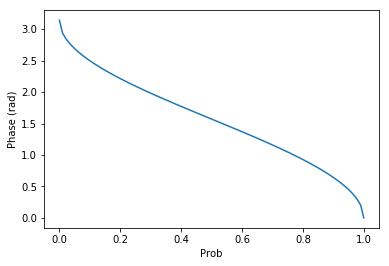

In [23]:
x = np.linspace(0,1,100)
y = np.arccos(2.0*x - 1.)
plt.plot()
plt.plot(x,y)
plt.xlabel('Prob')
plt.ylabel('Phase (rad)')
plt.show()

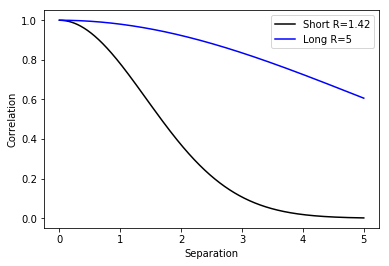

In [71]:
R1=1.42
R2=5
x = np.linspace(0,5,1000)
y1 = np.exp(-(x)**2 / 2.0*(1./(R1 + 1e-14))**2)
y2 = np.exp(-(x)**2 / 2.0*(1./(R2 + 1e-14))**2)
plt.plot()
plt.plot(x,y1, 'k',label='Short R='+str(R1))
plt.plot(x, y2, 'b', label='Long R='+str(R2))
plt.xlabel('Separation')
plt.ylabel('Correlation')
plt.legend(loc=0)
plt.show()